# Практическая работа №2

## Загрузка обученной модели и данных MNIST

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras.utils import to_categorical
(_, _), (test_images, test_labels) = datasets.mnist.load_data()

test_images = test_images / 255.0
test_labels = to_categorical(test_labels)
model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9742 - loss: 0.0828
Test accuracy on clean images: 0.9776999950408936


## Атака FSGM

In [14]:
import numpy as np

def fgsm_attack(image, epsilon, gradient):
    perturbed_image = image + epsilon * np.sign(gradient)
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image

def generate_adversarial_example(model, image, label, epsilon):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))
    label = tf.convert_to_tensor(label.reshape((1, 10)), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
    return adversarial_image

epsilon = 0.1
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

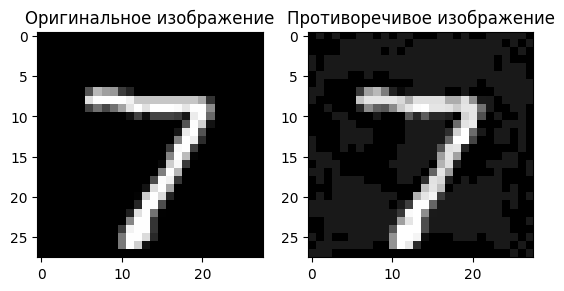

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

## Оценка модели

In [16]:
def generate_adversarial_dataset(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image.reshape(28, 28))
    adversarial_images = np.array(adversarial_images)
    print("Shape of adversarial_images:", adversarial_images.shape)
    return adversarial_images
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon)
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on a small subset of adversarial examples: {adversarial_acc}')

Shape of adversarial_images: (10000, 28, 28)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0829 - loss: 6.4847
Accuracy on a small subset of adversarial examples: 0.11289999634027481


Точность на чистых изображениях - 97%
Точность на противоречивых примерах - 11%